<a href="https://colab.research.google.com/github/judem-21/Word2Vec-Model/blob/main/NSampling_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Word2Vec model (with Negative Sampling)

####Importing Libraries

In [1]:
import torch,torchvision
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torchvision import transforms as transforms
#from torch.torchmetrics.text.bleu import BLEUScore

In [2]:
import os
import pandas as pd
from skimage import io
import spacy
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
!python -m spacy download en
spacy_eng = spacy.load("en_core_web_sm")

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import numpy as np
import torch.nn as nn
from sklearn.decomposition import PCA
import torch
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


####Dataset Loading

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
stop_words = set(stopwords.words('english'))
class Vocabulary:
    def __init__(self, freq_threshold=3):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
      return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
           lookup=self.tokenizer(sentence)
           for word in lookup:
            if word=='\n' or word in stop_words or word in string.punctuation: continue

            if word not in frequencies:
              frequencies[word] = 1

            else:
              frequencies[word] += 1

            if frequencies[word] == self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

In [7]:
class seq2seq_dataset:
    def __init__(self, data_file, num_samples=127584, freq_threshold=3):

        self.data = pd.read_csv(data_file).values[:num_samples]


        self.idx_sentences={}

        for idx,lines in enumerate(self.data):
            target_sentence = lines[0]
            self.idx_sentences[idx]=target_sentence

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.idx_sentences.values())

    def __len__(self):
        return len(self.idx_sentences_source)

In [40]:
dataset=seq2seq_dataset(data_file='/content/drive/MyDrive/Seq2SeqModel/output.csv',num_samples=8000,freq_threshold=4)

####Data PreProcess

In [13]:
def data_extraction(sentences,string2idx,window_size=2):
  data=[]
  for sentence in sentences:
    words=[tok.text.lower() for tok in spacy_eng.tokenizer(sentence)]
    for i in range(len(words)):
      token=words[i].lower()
      if token in string.punctuation or token in stop_words or token not in string2idx: continue
      for j in range(max(0,i-window_size),min(len(words),i+window_size+1)):
        if i!=j:
          if words[j].lower() not in stop_words and words[j] not in string.punctuation and words[j].lower() in string2idx:data.append([string2idx[words[i].lower()],string2idx[words[j].lower()]])
  return data

In [14]:
string2idx=dataset.vocab.stoi
data=data_extraction(sentences,string2idx,window_size=5)
data=torch.tensor(data)

####Model

In [16]:
class SkipGram_model(nn.Module):
  def __init__(self,vocab_size,embedding_dim):
    super(SkipGram_model,self).__init__()
    self.embeddings_centre=nn.Embedding(vocab_size,embedding_dim)
    self.embeddings_context=nn.Embedding(vocab_size,embedding_dim)

  def forward(self,centre,context):
    centre_embed=self.embeddings_centre(centre)
    context_embed=self.embeddings_context(context)
    scores=torch.cosine_similarity(centre_embed,context_embed,dim=1)
    return scores

In [33]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=SkipGram_model(vocab_size=len(string2idx),embedding_dim=32).to(device)
loss=nn.BCEWithLogitsLoss()

####Training

In [32]:
def train(model,centre,context,vocab_size,loss_function,optimizer,batch_size,num_epochs=1000,lr=0.01,negative_sampling_ratio=5,device='cuda'):
  num_batches=centre.shape[0]//batch_size
  epoch_loss=[]
  for epoch in range(num_epochs):
    batch_loss=[]
    for batch in range(num_batches):
      batch_centre=centre[batch*batch_size:(batch+1)*batch_size].to(device)
      batch_context=context[batch*batch_size:(batch+1)*batch_size].to(device)

      #positive_samples
      pos_label=torch.ones(batch_size).to(device)
      pos_out=model(batch_centre,batch_context)
      pos_loss=loss_function(pos_out,pos_label)

      #negative_samples
      counter=0
      neg_loss=0
      while counter<negative_sampling_ratio:
        neg_context=torch.randint(low=0,high=vocab_size,size=(batch_size,)).to(device)
        if (batch_context==neg_context).all() or (batch_centre==neg_context).any(): continue
        neg_label=torch.zeros(batch_size).to(device)
        neg_out=model(batch_centre,neg_context)
        neg_loss+=loss_function(neg_out,neg_label)
        counter+=1
      total_loss=pos_loss+(neg_loss/negative_sampling_ratio)
      batch_loss.append(total_loss.item())
      if (epoch==0 and batch==0) or (((epoch+1)%(num_epochs//5))==0 and ((batch+1)%1000)==0):
        print(f'Epoch {epoch+1}-Batch {batch+1}:- Loss={total_loss.item()}')
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
    total_loss=np.mean(batch_loss)
    epoch_loss.append(total_loss)
  return model,epoch_loss

In [ ]:
epochs=10000;lr=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
batch_size=64
total_samples=batch_size*(len(data)//batch_size)
centre=data[:total_samples,0]
context=data[:total_samples,1].to(device)
model,epoch_loss=train(model,centre,context,len(string2idx),loss,optimizer,batch_size,num_epochs=epochs,lr=lr,negative_sampling_ratio=5,device=device)

####Testing

Word embeddings shape: (100, 32)
pca shape: (100, 3)


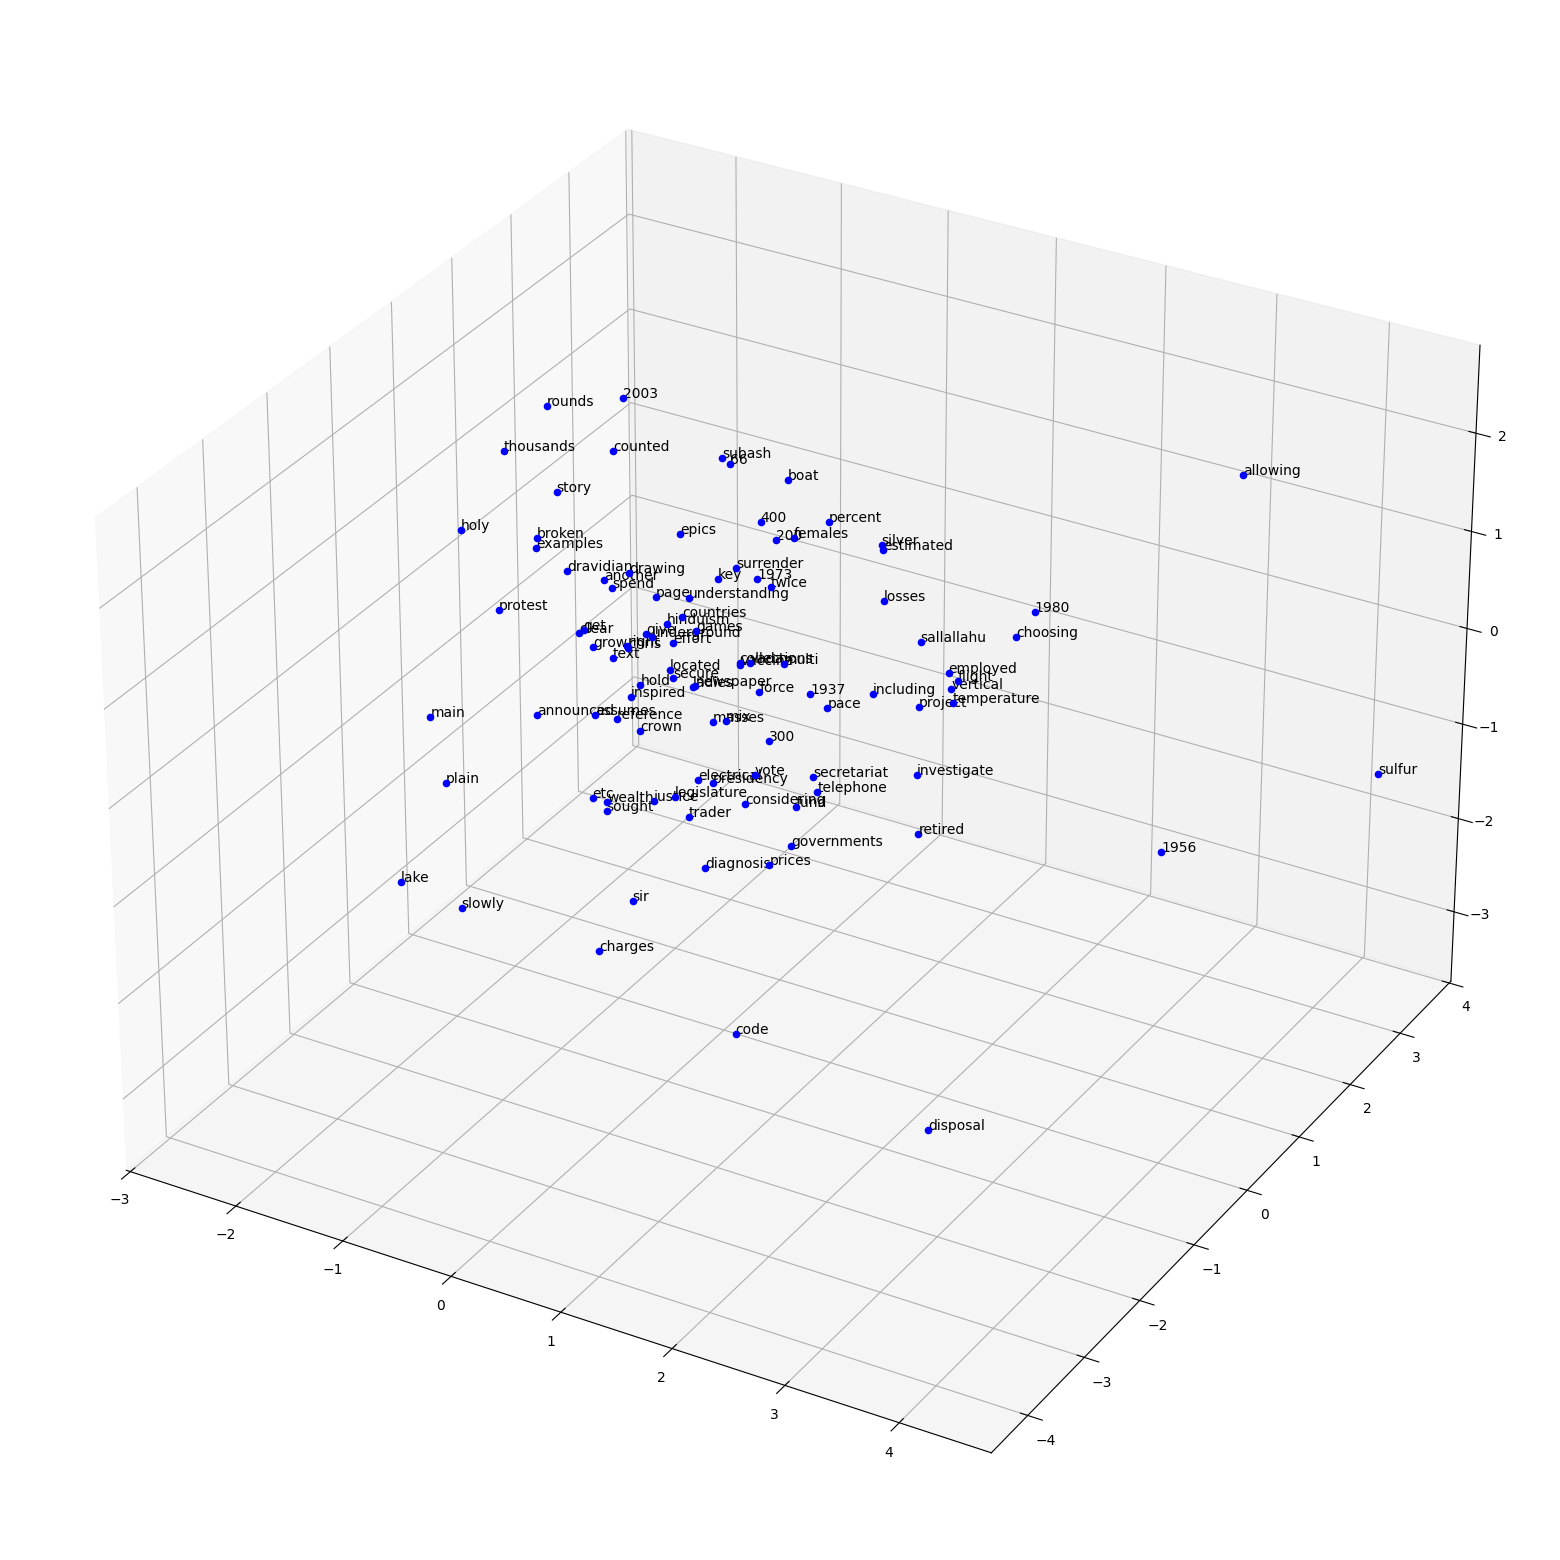

In [41]:
word_embeddings=model.embeddings_centre.weight.detach().cpu().numpy()
embedding_choices=np.random.choice(np.arange(len(string2idx)),size=100,replace=False)
print(f'Word embeddings shape: {word_embeddings[embedding_choices].shape}')
pca=PCA(n_components=3).fit_transform(word_embeddings[embedding_choices])
print(f'pca shape: {pca.shape}')
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(111,projection='3d')
for idx,word_idx in enumerate(embedding_choices):
    #print(word,idx)
    x,y,z=pca[idx]
    ax.scatter(x,y,z,color='blue')
    ax.text(x,y,z,dataset.vocab.itos[word_idx])
plt.show()